In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import random
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline

import qiskit
# from qiskit.visualization import
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix
# from qiskit.quantum_info.random.utils import random_state
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
# import qiskit.ignis.mitigation.measurement as mc

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
from qiskit import IBMQ
# loading roel's account
IBMQ.save_account('30c393d587101bddd683187f32510459f5c95e4d0afdf3da7ba96f18262de522fab6749335cb7504cc72eebf25110567ee03e7ea2ba29b644a3ab9e5a03a56f2')
IBMQ.active_account() # to check what account is active
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
simulator_noise = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmqx2') #ibmq_burlington ibmq_16_melbourne ibmq_ourense ibmqx2
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

Credentials already present. Set overwrite=True to overwrite.
C:\Users\Niels\Anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


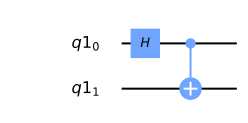

In [3]:
qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.h(0)
qc_expected.cx(0,1)
qc_expected.draw(output='mpl')

The expected state is: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


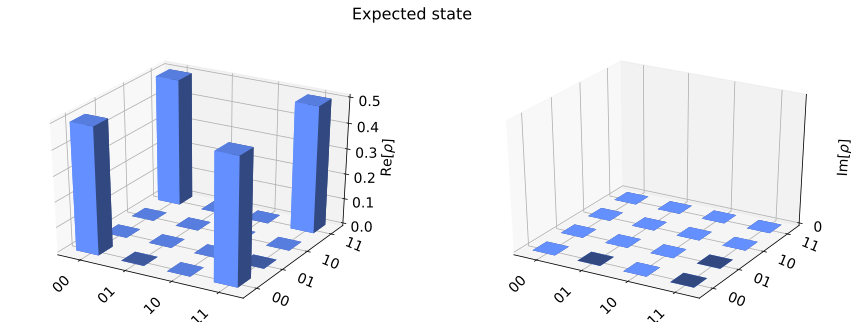

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

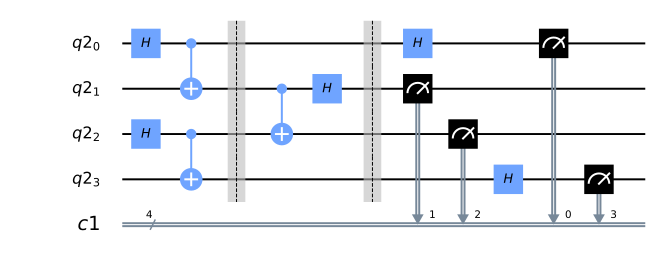

In [5]:
qr = QuantumRegister(4)
cr= ClassicalRegister(4)
qc1 = QuantumCircuit(qr)
qc1.h(0)
qc1.h(2)
qc1.cx(0,1)
qc1.cx(2,3)
qc1.barrier()
qc1.cx(1,2)
qc1.h(1)
qcz=state_tomography_circuits(qc1,[qr])
qct=[qcz[24],qcz[25],qcz[26],qcz[51],qcz[52],qcz[53],qcz[78],qcz[79],qcz[80]]
qct[0].draw(output='mpl')

In [6]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = qct[8].qregs[0], circlabel = 'measerrormitcal')
cal_job = qiskit.execute(cal_circuits,backend = device,shots = 8192,optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()

Job Status: job has successfully run


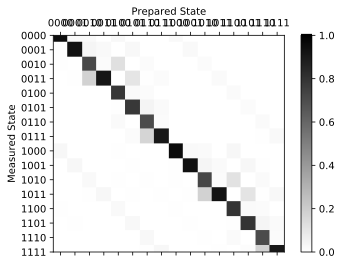

[-9.48181152e-02  8.58337402e-01  7.01904297e-04  8.54492188e-04]
[-1.51367188e-02  3.96728516e-04  9.34692383e-01 -9.15527344e-05]
[ 0.00292969 -0.01220703 -0.08874512  0.80212402]
[-0.09481812 -0.01513672  0.00292969]


In [7]:
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
counts =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
bits = [ '0000', '1000', '0001', '1001', '0010', '1010', '0011', '1011','0100', '1100', '0101',
        '1101', '0110', '1110', '0111', '1111']
for i in range(0,16):
    counts[i]=calres.get_counts(cal_circuits[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0
count = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for j in range(4):
    for num, bit in enumerate(bits):
        if num%4 == 0:
            for i in range(2):
                    count[i*4] += counts[2*j+i][bit]
                    count[i*4+8] += counts[2*j+i+8][bit]
        if num%4 == 2:
            for i in range(2):
                    count[i*4+1] += counts[2*j+i][bit]
                    count[i*4+9] += counts[2*j+i+8][bit]
        if num%4 == 1:
            for i in range(2):
                    count[i*4+2] += counts[2*j+i][bit]
                    count[i*4+10] += counts[2*j+i+8][bit]
        if num%4 == 3:
            for i in range(2):
                    count[i*4+3] += counts[2*j+i][bit]
                    count[i*4+11] += counts[2*j+i+8][bit]
countsdev = {'0000':count[0],'0001':count[1],'0010':count[2],'0011':count[3],'0100':count[4],
              '0101':count[5],'0110':count[6],'0111':count[7],'1000':count[8],'1001':count[9],
              '1010':count[10],'1011':count[11],'1100':count[12],'1101':count[13],'1110':count[14],
             '1111':count[15]}
m=[0,0,0,0]
minverse=np.array([[0.25,0.25,0.25,0.25],[0.25,0.25,-0.25,-0.25],[0.25,-0.25,0.25,-0.25],[0.25,-0.25,-0.25,0.25]])

#for mXX in range(2):
#    m[mXX]= (countsdev[bits[mXX]]*1 + countsdev[bits[mXX+2]]*(-1)+countsdev[bits[mXX+4]]*(-1)+countsdev[bits[mXX+6]]*1)/(countsdev[bits[mXX]]+countsdev[bits[mXX+2]]+countsdev[bits[mXX+4]]+countsdev[bits[mXX+6]])
#    m[mXX+1]= (countsdev[bits[mXX+8]]*1 + countsdev[bits[mXX+10]]*(-1)+countsdev[bits[mXX+12]]*(-1)+countsdev[bits[mXX+14]]*1)/(countsdev[bits[mXX+8]]+countsdev[bits[mXX+10]]+countsdev[bits[mXX+12]]+countsdev[bits[mXX+14]])
#beta_corr=np.dot(minverse,np.array([m[0],m[2],m[1],m[3]]))
#for mXX in range(2):
#    m[mXX]= (countsdev[bits[mXX]]*1 + countsdev[bits[mXX+2]]*(-1)+countsdev[bits[mXX+4]]*(1)+countsdev[bits[mXX+6]]*(-1))/(countsdev[bits[mXX]]+countsdev[bits[mXX+2]]+countsdev[bits[mXX+4]]+countsdev[bits[mXX+6]])
#    m[mXX+1]= (countsdev[bits[mXX+8]]*1 + countsdev[bits[mXX+10]]*(-1)+countsdev[bits[mXX+12]]*(1)+countsdev[bits[mXX+14]]*(-1))/(countsdev[bits[mXX+8]]+countsdev[bits[mXX+10]]+countsdev[bits[mXX+12]]+countsdev[bits[mXX+14]])
#beta_m=np.dot(minverse,np.array([m[0],m[2],m[1],m[3]]))
#for mXX in range(2):
#    m[mXX]= (countsdev[bits[mXX]]*1 + countsdev[bits[mXX+2]]*(1)+countsdev[bits[mXX+4]]*(-1)+countsdev[bits[mXX+6]]*(-1))/(countsdev[bits[mXX]]+countsdev[bits[mXX+2]]+countsdev[bits[mXX+4]]+countsdev[bits[mXX+6]])
#    m[mXX+1]= (countsdev[bits[mXX+8]]*1 + countsdev[bits[mXX+10]]*(1)+countsdev[bits[mXX+12]]*(-1)+countsdev[bits[mXX+14]]*(-1))/(countsdev[bits[mXX+8]]+countsdev[bits[mXX+10]]+countsdev[bits[mXX+12]]+countsdev[bits[mXX+14]])
#beta_l=np.dot(minverse,np.array([m[0],m[2],m[1],m[3]]))
#print(beta_l)
#print(beta_m)
#print(beta_corr)
countsnew = {'0000':0,'0001':0,'0010':0,'0011':0,'0100':0,
              '0101':0,'0110':0,'0111':0,'1000':0,'1001':0,
              '1010':0,'1011':0,'1100':0,'1101':0,'1110':0,
             '1111':0}
for bit in bits:
    countsnew[bit]=counts[0][bit]+counts[2][bit]+counts[4][bit]+counts[6][bit]
countsnew2 = {'00':countsnew['0000']+countsnew['0010']+countsnew['0100']+countsnew['0110'],
              '01':countsnew['0001']+countsnew['0011']+countsnew['0101']+countsnew['0111'],
              '10':countsnew['1000']+countsnew['1010']+countsnew['1100']+countsnew['1110'],
              '11':countsnew['1001']+countsnew['1011']+countsnew['1101']+countsnew['1111']}

m00m= (countsnew2["00"]*1 + countsnew2["01"]*(-1)+countsnew2["10"]*(1)+countsnew2["11"]*(-1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
m00l= (countsnew2["00"]*1 + countsnew2["01"]*(1)+countsnew2["10"]*(-1)+countsnew2["11"]*(-1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
m00corr= (countsnew2["00"]*1 + countsnew2["01"]*(-1)+countsnew2["10"]*(-1)+countsnew2["11"]*(1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
for bit in bits:
    countsnew[bit]=counts[8][bit]+counts[10][bit]+counts[12][bit]+counts[14][bit]
countsnew2 = {'00':countsnew['0000']+countsnew['0010']+countsnew['0100']+countsnew['0110'],
              '01':countsnew['0001']+countsnew['0011']+countsnew['0101']+countsnew['0111'],
              '10':countsnew['1000']+countsnew['1010']+countsnew['1100']+countsnew['1110'],
              '11':countsnew['1001']+countsnew['1011']+countsnew['1101']+countsnew['1111']}

m01m= (countsnew2["00"]*1 + countsnew2["01"]*(-1)+countsnew2["10"]*(1)+countsnew2["11"]*(-1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
m01l= (countsnew2["00"]*1 + countsnew2["01"]*(1)+countsnew2["10"]*(-1)+countsnew2["11"]*(-1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
m01corr= (countsnew2["00"]*1 + countsnew2["01"]*(-1)+countsnew2["10"]*(-1)+countsnew2["11"]*(1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
for bit in bits:
    countsnew[bit]=counts[1][bit]+counts[3][bit]+counts[5][bit]+counts[7][bit]
countsnew2 = {'00':countsnew['0000']+countsnew['0010']+countsnew['0100']+countsnew['0110'],
              '01':countsnew['0001']+countsnew['0011']+countsnew['0101']+countsnew['0111'],
              '10':countsnew['1000']+countsnew['1010']+countsnew['1100']+countsnew['1110'],
              '11':countsnew['1001']+countsnew['1011']+countsnew['1101']+countsnew['1111']}

m10m= (countsnew2["00"]*1 + countsnew2["01"]*(-1)+countsnew2["10"]*(1)+countsnew2["11"]*(-1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
m10l= (countsnew2["00"]*1 + countsnew2["01"]*(1)+countsnew2["10"]*(-1)+countsnew2["11"]*(-1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
m10corr= (countsnew2["00"]*1 + countsnew2["01"]*(-1)+countsnew2["10"]*(-1)+countsnew2["11"]*(1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
for bit in bits:
    countsnew[bit]=counts[9][bit]+counts[11][bit]+counts[13][bit]+counts[15][bit]    
countsnew2 = {'00':countsnew['0000']+countsnew['0010']+countsnew['0100']+countsnew['0110'],
              '01':countsnew['0001']+countsnew['0011']+countsnew['0101']+countsnew['0111'],
              '10':countsnew['1000']+countsnew['1010']+countsnew['1100']+countsnew['1110'],
              '11':countsnew['1001']+countsnew['1011']+countsnew['1101']+countsnew['1111']}

m11m= (countsnew2["00"]*1 + countsnew2["01"]*(-1)+countsnew2["10"]*(1)+countsnew2["11"]*(-1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
m11l= (countsnew2["00"]*1 + countsnew2["01"]*(1)+countsnew2["10"]*(-1)+countsnew2["11"]*(-1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
m11corr= (countsnew2["00"]*1 + countsnew2["01"]*(-1)+countsnew2["10"]*(-1)+countsnew2["11"]*(1))/(countsnew2["00"]+countsnew2["01"]+countsnew2["10"]+countsnew2["11"])
    
m=np.array([[1,1,1,1],[1,1,-1,-1],[1,-1,1,-1],[1,-1,-1,1]])
beta_m=np.dot(inv(m),np.array([m00m,m01m,m10m,m11m]))
print(beta_m)
beta_l=np.dot(inv(m),np.array([m00l,m01l,m10l,m11l]))
print(beta_l)
beta_corr=np.dot(inv(m),np.array([m00corr,m01corr,m10corr,m11corr]))
print(beta_corr)
B=np.array([beta_m[1:],beta_l[1:],beta_corr[1:]])
B0=np.array([beta_m[0],beta_l[0],beta_corr[0]])
print(B0)
#plot_histogram(countsnew2)
#cal_circuits[9].draw(output='mpl')

In [8]:
backends = [simulator,device,0]
result =[0,0,0,0]
paulis = [('X','Z','Z','X'),('Y','Z','Z','X'),('Z','Z','Z','X'),('X','Z','Z','Y'),('Y','Z','Z','Y'),('Z','Z','Z','Y'),('X','Z','Z','Z'),('Y','Z','Z','Z'),('Z','Z','Z','Z')]
basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
for be, backend in enumerate(backends):
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '10': 0,'01': 0, '11': 0}})
    state_df = pd.DataFrame(data=[state,state,state,state])
    if be == 0:
        job = qiskit.execute(qct, simulator, shots=8192)
        #,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
    if be == 1:
        job = qiskit.execute(qct, device, shots=8192)
        job_monitor(job)
        result[be] = job.result()
    if be == 2:
        tom = StateTomographyFitter(meas_filter.apply(result[be-1]),qct)
    else:
        tom = StateTomographyFitter(job.result(), qct)
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    for i in range(4):
        for j in range(9):
            state_df.loc[i][basis[j]] = {'00': tom.data[(paulis[j])][bits[4*i]],
                                         '10': tom.data[(paulis[j])][bits[4*i+1]],
                                         '01': tom.data[(paulis[j])][bits[4*i+2]],
                                         '11': tom.data[(paulis[j])][bits[4*i+3]]}
    if be == 0:
        state_sim = state_df
        print('The full state for simulator is', state_df)
    if be == 1:
        state_dev = state_df
        print('The full state for device is', state_df)
        x=0
    if be == 2:
        state_err = state_df
        print('The corrected state for device is', state_df)

The full state for simulator is                                            XX  \
0   {'00': 1003, '10': 0, '01': 0, '11': 999}   
1  {'00': 0, '10': 1020, '01': 1037, '11': 0}   
2   {'00': 999, '10': 0, '01': 0, '11': 1050}   
3  {'00': 0, '10': 1078, '01': 1006, '11': 0}   

                                             YX  \
0  {'00': 493, '10': 499, '01': 514, '11': 548}   
1  {'00': 502, '10': 532, '01': 505, '11': 506}   
2  {'00': 505, '10': 502, '01': 523, '11': 506}   
3  {'00': 500, '10': 508, '01': 527, '11': 522}   

                                             ZX  \
0  {'00': 456, '10': 542, '01': 492, '11': 552}   
1  {'00': 498, '10': 495, '01': 539, '11': 514}   
2  {'00': 504, '10': 526, '01': 509, '11': 500}   
3  {'00': 518, '10': 496, '01': 542, '11': 509}   

                                             XY  \
0  {'00': 515, '10': 489, '01': 504, '11': 513}   
1  {'00': 511, '10': 495, '01': 524, '11': 505}   
2  {'00': 519, '10': 500, '01': 492, '11': 502}   
3  {'0

In [9]:
XXPaul = np.matrix('0,0,0,1;0,0,1,0;0,1,0,0;1,0,0,0')
XYPaul = np.matrix('0,0,0,0-1j;0,0,0+1j,0;0,0-1j,0,0;0+1j,0,0,0')
XZPaul = np.matrix('0,0,1,0;0,0,0,-1;1,0,0,0;0,-1,0,0')
Iden = np.matrix('1,0,0,0;0,1,0,0;0,0,1,0;0,0,0,1')
YXPaul = np.matrix('0,0,0,0-1j;0,0,0-1j,0;0,0+1j,0,0;0+1j,0,0,0')
YYPaul = np.matrix('0,0,0,-1;0,0,1,0;0,1,0,0;-1,0,0,0')
YZPaul = np.matrix('0,0,0-1j,0;0,0,0,0+1j;0+1j,0,0,0;0,0-1j,0,0')
ZXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,-1;0,0,-1,0')
ZYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0+1j;0,0,0-1j,0')
ZZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,-1,0;0,0,0,1')
IXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,1;0,0,1,0')
IYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0-1j;0,0,0+1j,0')
IZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,1,0;0,0,0,-1')
XIPaul = np.matrix('0,0,1,0;0,0,0,1;1,0,0,0;0,1,0,0')
YIPaul = np.matrix('0,0,0-1j,0;0,0,0,0-1j;0+1j,0,0,0;0,0+1j,0,0')
ZIPaul = np.matrix('1,0,0,0;0,1,0,0;0,0,-1,0;0,0,0,-1')

r_exp=np.zeros((4, 9))
ri_exp=np.zeros((4, 9))
ri2_exp=np.zeros((4, 9))
riav_exp=np.zeros((4, 3))
riav2_exp=np.zeros((4, 3))

r_exp2=np.zeros((4, 9))
ri_exp2=np.zeros((4, 9))
ri2_exp2=np.zeros((4, 9))
riav_exp2=np.zeros((4, 3))
riav2_exp2=np.zeros((4, 3))
state_tot=[state_sim,state_err,state_dev,0] #[state_sim,state_err,state_dev,0]
rhof=[0,0,0,0]
rho2=[0,0,0,0]
basis2 = ['XX','XY','XZ','YX','YY','YZ','ZX','ZY','ZZ']

for stat, states in enumerate(state_tot):
    rhof=[0,0,0,0]
    if stat == 3:
        for i in range(4):
            for j in range(3):
                for k in range(3):
                    p=np.dot(inv(B),(np.array([ri2_exp[i,j],ri_exp[i,k],r_exp[i,j*3+k]])-B0))
                    r_exp2[i,j*3+k]=p[2]
                    if j==0:
                        ri_exp2[i,k]=p[1]
                ri2_exp2[i,j]=p[0]
    else:
        for i in range(4):
            for j in range(9):
                r_exp[i,j] = (state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(-1)+state_tot[stat][basis[j]][i]['01']*(-1)+state_tot[stat][basis[j]][i]['11']*1)/(state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1)+state_tot[stat][basis[j]][i]['01']*(1)+state_tot[stat][basis[j]][i]['11']*1)
                ri_exp[i,j] = (state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1)+state_tot[stat][basis[j]][i]['01']*(-1)+state_tot[stat][basis[j]][i]['11']*(-1))/(state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1)+state_tot[stat][basis[j]][i]['01']*(1)+state_tot[stat][basis[j]][i]['11']*1)
                ri2_exp[i,j] = (state_tot[stat][basis2[j]][i]['00']*1 + state_tot[stat][basis2[j]][i]['10']*(-1)+state_tot[stat][basis2[j]][i]['01']*(1)+state_tot[stat][basis2[j]][i]['11']*(-1))/(state_tot[stat][basis2[j]][i]['00']*1 + state_tot[stat][basis2[j]][i]['10']*(1)+state_tot[stat][basis2[j]][i]['01']*(1)+state_tot[stat][basis2[j]][i]['11']*1)
    if stat == 3:
        for i in range(4):
            for j in range(3):
                    riav_exp2[i,j]=(ri_exp2[i,3*j]+ri_exp2[i,3*j+1]+ri_exp2[i,3*j+2])/3
                    riav2_exp2[i,j]=(ri2_exp2[i,3*j]+ri2_exp2[i,3*j+1]+ri2_exp2[i,3*j+2])/3
        for i in range(4):
            rhof[i] = (1/4)*(Iden+r_exp2[i,0]*XXPaul+r_exp2[i,1]*XYPaul+r_exp2[i,2]*XZPaul+
                             r_exp2[i,3]*YXPaul+r_exp2[i,4]*YYPaul+r_exp2[i,5]*YZPaul+r_exp2[i,6]*ZXPaul+
                             r_exp2[i,7]*ZYPaul+r_exp2[i,8]*ZZPaul+riav_exp2[i,0]*IXPaul+riav2_exp2[i,0]*XIPaul+
                             riav_exp2[i,1]*IYPaul+riav2_exp2[i,1]*YIPaul+riav_exp2[i,2]*IZPaul+
                             riav2_exp2[i,2]*ZIPaul)
    else:
        for i in range(4):
            for j in range(3):
                    riav_exp[i,j]=(ri_exp[i,3*j]+ri_exp[i,3*j+1]+ri_exp[i,3*j+2])/3
                    riav2_exp[i,j]=(ri2_exp[i,3*j]+ri2_exp[i,3*j+1]+ri2_exp[i,3*j+2])/3
        for i in range(4):
            rhof[i] = (1/4)*(Iden+r_exp[i,0]*XXPaul+r_exp[i,1]*XYPaul+r_exp[i,2]*XZPaul+
                             r_exp[i,3]*YXPaul+r_exp[i,4]*YYPaul+r_exp[i,5]*YZPaul+r_exp[i,6]*ZXPaul+
                             r_exp[i,7]*ZYPaul+r_exp[i,8]*ZZPaul+riav_exp[i,0]*IXPaul+riav2_exp[i,0]*XIPaul+
                             riav_exp[i,1]*IYPaul+riav2_exp[i,1]*YIPaul+riav_exp[i,2]*IZPaul+
                             riav2_exp[i,2]*ZIPaul)
    rho2[stat]=rhof
rho = pd.DataFrame(data=[rho2[0],rho2[1],rho2[2],rho2[3]])
for ind in range(3):
    rho.loc[ind][1] = ZIPaul @ rho.loc[ind][1] @ ZIPaul
    rho.loc[ind][2] = XIPaul @ rho.loc[ind][2] @ XIPaul
    rho.loc[ind][3] = XIPaul @ ZIPaul @ rho.loc[ind][3] @ ZIPaul @ XIPaul

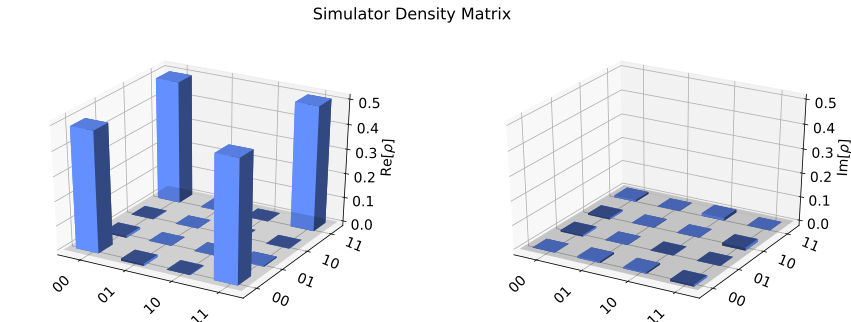

In [10]:
finstate= rho[0][0]
plot_state_city(finstate, title='Simulator Density Matrix')

In [11]:
Fidelity = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        Fidelity[i,j] = state_fidelity(psi_expected, rho[j][i], validate=False)     
F = np.mean(Fidelity,axis=1)
print('Simulator Fidelity:', F[0]) #Noisy
print('Corrected Device Fidelity:', F[1])
print('Device Fidelity:', F[2])
print('Corrected Device Fidelity:', F[3])

Simulator Fidelity: 1.0
Corrected Device Fidelity: 0.9110963406819228
Device Fidelity: 0.7455151974836765
Corrected Device Fidelity: 0.25172045511797386


In [12]:
rho_sim = DensityMatrix(rho[0][0])
rho_dev = DensityMatrix(rho[3][0])
print('Is the simulator density matrix valid?', rho_sim.is_valid())
print('Is the device density matrix valid?', rho_dev.is_valid())

Is the simulator density matrix valid? False
Is the device density matrix valid? False
